Target Hs = 2.000 m, Estimated Hs from PSD = 2.000 m
Chosen frequencies (Hz): [0.04  , 0.0488, 0.0601, 0.0737, 0.0903, 0.1108, 0.1357, 0.1665, 0.2041,
 0.25  ]


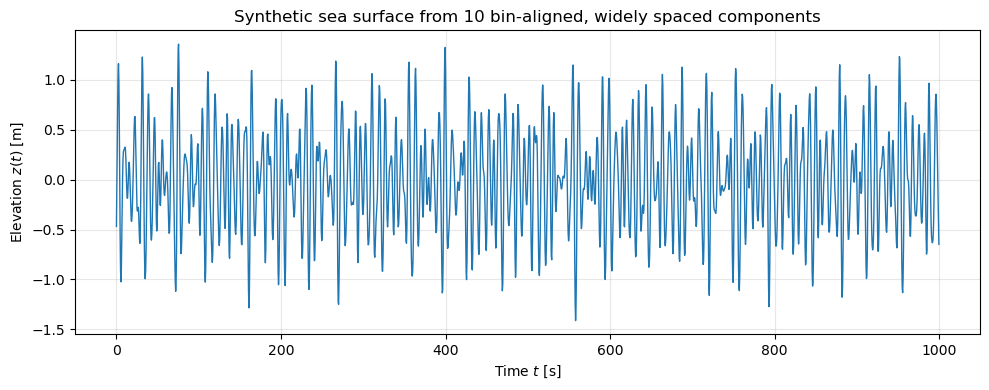

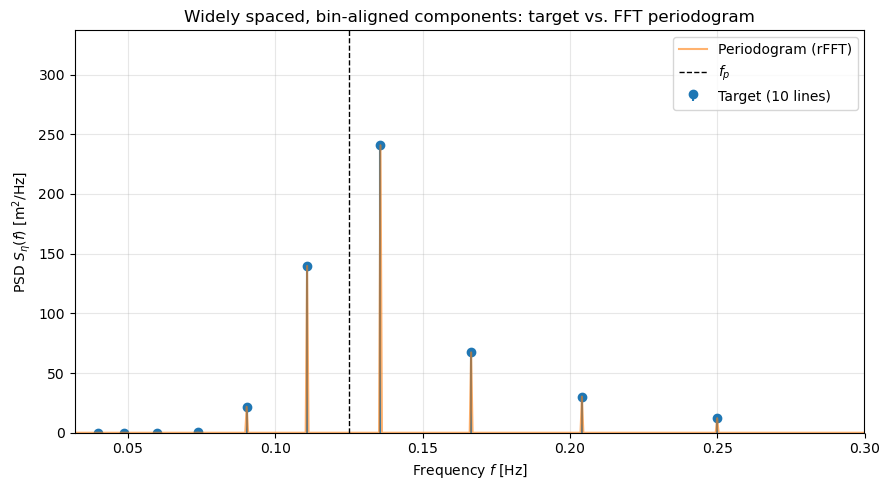

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Sea-state & synthesis settings
# -----------------------------
Hs    = 2.0         # significant wave height [m]
Tp    = 8.0         # peak period [s]
gamma = 3.3         # JONSWAP peak enhancement
fs    = 2.0         # sampling rate [Hz]
N     = 4096        # number of samples
dt    = 1/fs
t     = np.arange(N) * dt
df    = fs / N
fp    = 1.0 / Tp
f_bins = np.fft.rfftfreq(N, d=dt)  # FFT bin centers (one-sided)

# -----------------------------
# Choose widely separated freqs (bin-aligned)
# -----------------------------
# Target band and geometric spacing (well separated)
fmin, fmax = 0.04, 0.25          # Hz (adjust to taste)
Ncomp = 10
f_targets = np.geomspace(fmin, fmax, Ncomp)

# Snap to nearest FFT bins, avoid DC (bin 0) and Nyquist (last bin)
k = np.clip(np.round(f_targets / df).astype(int), 1, len(f_bins)-2)
# Ensure uniqueness if two targets round to same bin
k = np.unique(k)

# If rounding collapsed the count, expand outward from the peak bin(s)
while len(k) < Ncomp:
    # Try adding neighbors (skipping DC/Nyquist)
    candidates = np.setdiff1d(np.r_[k-1, k+1], np.r_[0, len(f_bins)-1])
    k = np.unique(np.r_[k, candidates])
    if len(k) > Ncomp:
        k = np.sort(k)[:Ncomp]

# Final, sorted indices and frequencies
k = np.sort(k)[:Ncomp]
f = f_bins[k]

# -----------------------------
# JONSWAP-like shape at these bins
# -----------------------------
sigma = np.where(f <= fp, 0.07, 0.09)
expo  = np.exp(-0.5 * ((f/fp - 1.0)/sigma)**2)
S_shape = (f**-5) * np.exp(-1.25*(fp/f)**4) * (gamma**expo)

# Scale to target variance m0 = (Hs/4)^2
m0_target = (Hs/4.0)**2
m0_shape  = np.sum(S_shape) * df
scale     = m0_target / m0_shape
S_target  = scale * S_shape

# -----------------------------
# Convert S(f_k) -> sine amplitudes; random phases
# -----------------------------
a     = np.sqrt(2.0 * S_target * df)
phi   = np.random.default_rng(7).uniform(0, 2*np.pi, len(a))
omega = 2*np.pi*f

# -----------------------------
# Synthesize time series
# -----------------------------
z = np.zeros_like(t)
for ak, wk, ph in zip(a, omega, phi):
    z += ak * np.sin(wk * t + ph)

# -----------------------------
# One-sided periodogram (rFFT)
# S_est = (2 / (fs * N)) * |Z|^2  (halve DC/Nyquist)
# -----------------------------
Z     = np.fft.rfft(z)
S_est = (2.0 / (fs * N)) * (np.abs(Z)**2)
S_est[0] *= 0.5
if N % 2 == 0:
    S_est[-1] *= 0.5

# -----------------------------
# Quick checks
# -----------------------------
m0_est = np.sum(S_est) * df
Hs_est = 4*np.sqrt(m0_est)
print(f"Target Hs = {Hs:.3f} m, Estimated Hs from PSD = {Hs_est:.3f} m")
print("Chosen frequencies (Hz):", np.array2string(f, precision=4, separator=", "))

# -----------------------------
# Plots
# -----------------------------
# Time series (show ~1000 s)
plt.figure(figsize=(10,4))
plt.plot(t[:2000], z[:2000], lw=1)
plt.xlabel('Time $t$ [s]')
plt.ylabel('Elevation $z(t)$ [m]')
plt.title('Synthetic sea surface from 10 bin-aligned, widely spaced components')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Spectrum comparison across full band of interest
plt.figure(figsize=(9,5))
plt.stem(f, S_target, basefmt=' ', label='Target (10 lines)')
plt.plot(f_bins, S_est, '-', alpha=0.6, label='Periodogram (rFFT)')
plt.axvline(fp, color='k', ls='--', lw=1, label='$f_p$')
plt.xlim(fmin*0.8, fmax*1.2)
plt.ylim(0.7*np.min(S_target), 1.4*np.max(S_target))
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('PSD $S_\\eta(f)$ [$\\mathrm{m}^2/\\mathrm{Hz}$]')
plt.title('Widely spaced, bin-aligned components: target vs. FFT periodogram')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


Hs target = 2.00 m | Hs(aligned) = 2.00 m | Hs(detuned) = 2.00 m
Aligned freqs (Hz): [0.04  , 0.0488, 0.0601, 0.0737, 0.0903, 0.1108, 0.1357, 0.1665, 0.2041,
 0.25  ]
Detuned  freqs (Hz): [0.0402, 0.0487, 0.0602, 0.0736, 0.0905, 0.1107, 0.1359, 0.1664, 0.2042,
 0.2499]


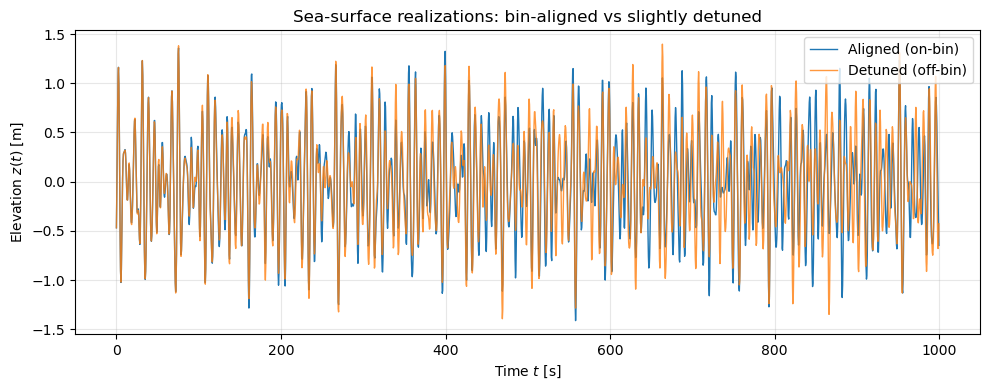

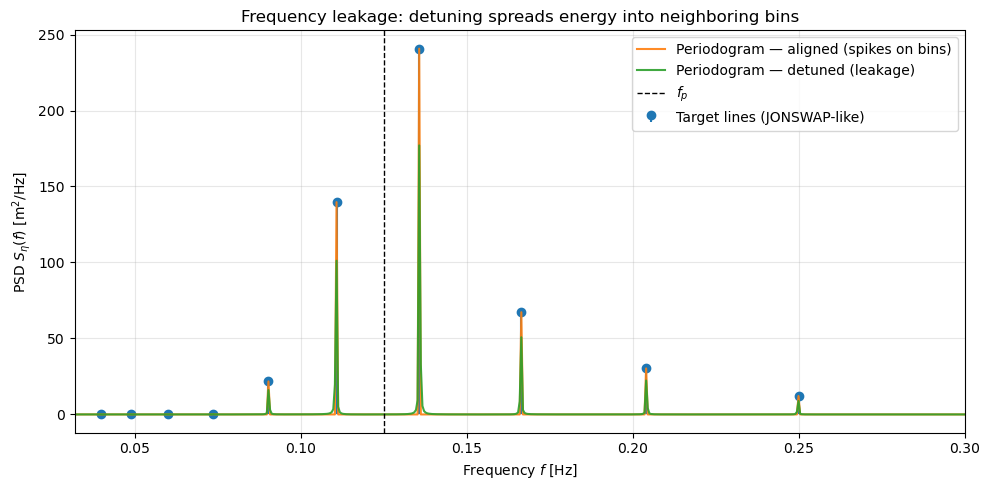

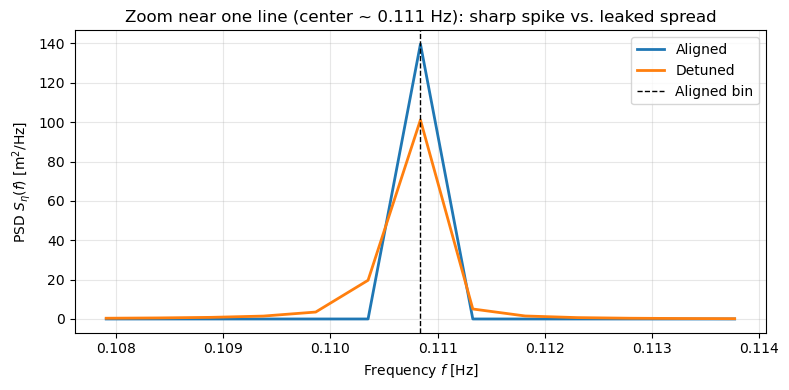

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Sea-state & FFT settings
# -----------------------------
Hs    = 2.0         # significant wave height [m]
Tp    = 8.0         # peak period [s]
gamma = 3.3         # JONSWAP peak enhancement
fs    = 2.0         # sampling rate [Hz]
N     = 4096        # number of samples
dt    = 1/fs
t     = np.arange(N) * dt
df    = fs / N
fp    = 1.0 / Tp
f_bins = np.fft.rfftfreq(N, d=dt)  # one-sided bin centers (0..fs/2)

# -----------------------------
# Choose widely separated bin-aligned freqs
# -----------------------------
fmin, fmax = 0.04, 0.25   # Hz
Ncomp = 10
f_targets = np.geomspace(fmin, fmax, Ncomp)   # wide band, geometric spacing
k = np.clip(np.round(f_targets / df).astype(int), 1, len(f_bins)-2)  # snap to bins (avoid DC/Nyquist)
k = np.unique(k)

# ensure we end up with exactly Ncomp bins (add neighbors if rounding collided)
while len(k) < Ncomp:
    candidates = np.setdiff1d(np.r_[k-1, k+1], np.r_[0, len(f_bins)-1])
    k = np.unique(np.r_[k, candidates])
    if len(k) > Ncomp:
        k = np.sort(k)[:Ncomp]
k = np.sort(k)[:Ncomp]
f_aligned = f_bins[k]

# -----------------------------
# JONSWAP-like shape at chosen bins (density shape; scale later)
# -----------------------------
sigma = np.where(f_aligned <= fp, 0.07, 0.09)
expo  = np.exp(-0.5 * ((f_aligned/fp - 1.0)/sigma)**2)
S_shape = (f_aligned**-5) * np.exp(-1.25*(fp/f_aligned)**4) * (gamma**expo)

# Scale PSD so that sum S * df = m0_target = (Hs/4)^2
m0_target = (Hs/4.0)**2
m0_shape  = np.sum(S_shape) * df
scale     = m0_target / m0_shape
S_target  = scale * S_shape

# Convert PSD density -> amplitudes for each discrete line
a = np.sqrt(2.0 * S_target * df)

# Phases (hold fixed so only frequency shift changes the outcome)
rng = np.random.default_rng(7)
phi = rng.uniform(0, 2*np.pi, Ncomp)

# -----------------------------
# Build two signals: aligned vs detuned (off-bin)
# -----------------------------
# Small detuning: shift each line by +/- 0.3 of a bin, alternating directions
detune_fraction = 0.30
sign = np.where(np.arange(Ncomp) % 2 == 0, +1.0, -1.0)
f_detuned = f_aligned + sign * detune_fraction * df

# time series from aligned frequencies
z_aligned = np.zeros_like(t)
for ak, fk, ph in zip(a, f_aligned, phi):
    z_aligned += ak * np.sin(2*np.pi*fk * t + ph)

# time series from slightly detuned frequencies
z_detuned = np.zeros_like(t)
for ak, fk, ph in zip(a, f_detuned, phi):
    z_detuned += ak * np.sin(2*np.pi*fk * t + ph)

# -----------------------------
# Periodograms (rFFT), one-sided, consistent scaling
# S_est = (2 / (fs * N)) * |Z|^2 ; halve DC/Nyquist
# -----------------------------
def periodogram_onesided(x, fs):
    N = len(x)
    Z = np.fft.rfft(x)
    S = (2.0 / (fs * N)) * (np.abs(Z)**2)
    S[0] *= 0.5
    if N % 2 == 0:
        S[-1] *= 0.5
    freqs = np.fft.rfftfreq(N, d=1/fs)
    return freqs, S

f_est, S_align = periodogram_onesided(z_aligned, fs)
_,     S_det   = periodogram_onesided(z_detuned, fs)

# Consistency check: Hs from PSD
m0_align = np.sum(S_align) * df
m0_det   = np.sum(S_det)   * df
print(f"Hs target = {Hs:.2f} m | Hs(aligned) = {4*np.sqrt(m0_align):.2f} m | Hs(detuned) = {4*np.sqrt(m0_det):.2f} m")
print("Aligned freqs (Hz):", np.array2string(f_aligned, precision=4, separator=", "))
print("Detuned  freqs (Hz):", np.array2string(f_detuned,  precision=4, separator=", "))

# -----------------------------
# Plots
# -----------------------------
# 1) Short snippet of time series (both)
plt.figure(figsize=(10,4))
plt.plot(t[:2000], z_aligned[:2000], label='Aligned (on-bin)', lw=1)
plt.plot(t[:2000], z_detuned[:2000], label='Detuned (off-bin)', lw=1, alpha=0.8)
plt.xlabel('Time $t$ [s]')
plt.ylabel('Elevation $z(t)$ [m]')
plt.title('Sea-surface realizations: bin-aligned vs slightly detuned')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Spectra comparison over the band of interest (linear scale to see leakage)
plt.figure(figsize=(10,5))
plt.stem(f_aligned, S_target, basefmt=' ', label='Target lines (JONSWAP-like)')
plt.plot(f_est, S_align,  '-', alpha=0.9,  label='Periodogram — aligned (spikes on bins)')
plt.plot(f_est, S_det,    '-', alpha=0.9,  label='Periodogram — detuned (leakage)')
plt.axvline(fp, color='k', ls='--', lw=1, label='$f_p$')
plt.xlim(fmin*0.8, fmax*1.2)
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('PSD $S_\\eta(f)$ [$\\mathrm{m}^2/\\mathrm{Hz}$]')
plt.title('Frequency leakage: detuning spreads energy into neighboring bins')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Zoom around one component to highlight the sinc-like spread
# pick the middle component to zoom on
mid = Ncomp // 2
f0 = f_aligned[mid]
span = 6 * df
mask = (f_est >= f0 - span) & (f_est <= f0 + span)

plt.figure(figsize=(8,4))
plt.plot(f_est[mask], S_align[mask],  label='Aligned', lw=2)
plt.plot(f_est[mask], S_det[mask],    label='Detuned', lw=2)
plt.axvline(f0, color='k', ls='--', lw=1, label='Aligned bin')
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('PSD $S_\\eta(f)$ [$\\mathrm{m}^2/\\mathrm{Hz}$]')
plt.title(f'Zoom near one line (center ~ {f0:.3f} Hz): sharp spike vs. leaked spread')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
